# IndiaSim Graph-Style ABM Model Prototype

In [1]:
#import Pkg # for installing packages/package manager
## get packages that are necessary or install them if they don't exist in the current environment
#Pkg.add(["Agents", "Random", "DataFrames", "LightGraphs", "Distributions", "DrWatson", "Plots","StatsBase",
# "CSV", "DataStructures"])

In [2]:
using Agents, Random, DataFrames, LightGraphs, CSV, DataStructures
using Distributions: Poisson, DiscreteNonParametric, Uniform, NegativeBinomial, Geometric
using DrWatson: @dict
using Plots

Whenever iterating through states and districts to add features by district in this code, it is imperative to iterate in the same order every time so that other dynamics are preserved. <br>for state in keys(model.states_districts)
                                <br>for district in model.states_districts[state]
                                    <br>...
                                <br>end
                             <br>end

In [3]:
#Below function is used to model the transmission rate that decreases by an exponential scale nearing the end of the
    #infection period
function exponential_decay(first,last,steps)
    multiplicative_factor=(last/first)^(1/steps)    
    return multiplicative_factor.^(1:steps).*first
end


exponential_decay (generic function with 1 method)

In [4]:
#Sample individual reproductive number using geometric distribution
function R_distribution(age,mean_R0,Fi_vals)
    r_val=(rand(Geometric((1 - 2*Fi_vals[age+1]) / (1 - Fi_vals[age+1])))+1) * mean_R0 * (1 - Fi_vals[age+1])/(1 - 2*Fi_vals[age+1])
    #println("r_val ",r_val)
    return r_val
end

R_distribution (generic function with 1 method)

In [5]:
antibiotics_vaccination_df = DataFrame(CSV.File("antibiotics_childhood_vaccination.csv"))
under_two_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"0-23").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
two_to_five_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
five_plus_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
five_plus_factor=(five_plus_vaccination_abx[2]-five_plus_vaccination_abx[1])/2
five_plus_vaccination_abx[1]-=five_plus_factor
five_plus_vaccination_abx[2]+=five_plus_factor

#This function uses agent age and reproductive number; it calculates tranmission rate by day for each day of infection.
    #It also determines whether the agent will die, and days of infection until death if so, and whether the agent
    #will take antibiotics, and the day if so.
function transmission_rate(age, wealth, vaccine_efficacy, R0_mean, Fi_vals, days_incubate=rand(1:3),days_increase=rand(1:5),
    days_decrease_linear=rand(3:9), days_decrease_exponential=rand(5:25))   
    
    #Scaling the reproductive number based on differential # of contacts by age
    #scales mean R0 by total contacts given agent age using gamma distribution sampling
    reproductive_number=R_distribution(age,R0_mean,Fi_vals)    
    
    
    transmission_scale=zeros(days_incubate)
    
    if days_increase<2
        increase_linear=Float64[1]
    else
        increase_linear=LinRange(0,1,days_increase+1) #Need to add 1 to function because LinRange adds 0 as first value
        increase_linear=increase_linear[2:length(increase_linear)]#Remove the 0 added by LinRange
    end
    append!(transmission_scale,increase_linear)
    
    if days_decrease_linear<2
        decrease_linear=rand(Uniform(1/3,2/3))
    
    else
        decrease_linear=LinRange(1,rand(Uniform(1/3,2/3)),days_decrease_linear+1) #Need to add 1 to function because LinRange adds 1 as first value
        decrease_linear=decrease_linear[2:length(decrease_linear)] #Remove the 1 added by LinRange
    end
    append!(transmission_scale,decrease_linear)
    append!(transmission_scale,exponential_decay(transmission_scale[length(transmission_scale)],rand(Uniform(1/100,1/5)),days_decrease_exponential))
    
    if age<5#carriage rate data from https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0246522&type=printable
        
        if age<2
            if age<1
                carriage_prob=0.152
            else
                carriage_prob = 0.019
            end
        else
            carriage_prob=0.004
        end
    else
        carriage_prob=0
    end
    
    carrier = false
    #Below if statement determines whether agent is a carrier and will have the transmissible infection for a 
        #prolongued period of time
    
    
    #This is the transmission rate if the agent is not a carrier, adding additional transmission days in if statement below 
            #if agent is a carrier  
    
    transmission_scale=transmission_scale.*(reproductive_number/sum(transmission_scale))
    
    if rand(Uniform(0,1))<carriage_prob
        days_carrier = trunc(Int,round(1/(rand(Uniform(0.64,0.75))/30)))-length(transmission_scale)+days_incubate 
        carrier = true
        #monthly carriage clearance data from https://doi.org/10.1186/1471-2334-9-102. Accounting for all other days of infection
        #that technically count as carriage (aside from incubation period)
        
        #If a carrier, the reproductive number is 1 over the remaining days of carriage (note the 1/days_carrier)
        append!(transmission_scale, repeat([1/days_carrier],days_carrier))
    end
            
    #default is no antibiotics; if agent is not a carrier, will seek antibiotics. Chance of seeking antibiotics if vaccinated
    days_till_antibiotic=-1
    
    if carrier==false #If not carrier, agent will seek antibiotics 1-5 days after onset of symptoms
        if vaccine_efficacy>0 #If vaccinated, transmission rate and death probability are reduced; below is also
                                #the probability they will seek antibiotics (based on age)
            transmission_scale.*0.75 #reduced transmission rate by arbitrary 25%
            
            if age<2
                if age<1 #if 0-1 yrs old
                    #Accounting for the -0.066 in the CI of -0.066 to 0.19
                    if vaccine_efficacy<vaccine_efficacy_low_bound+
                            (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(under_two_vaccination_abx[1])/
                        (abs(under_two_vaccination_abx[1])+under_two_vaccination_abx[2])
                        days_till_antibiotic=days_incubate + rand(1:5)

                    elseif rand(Uniform(0,1))> rand(Uniform(under_two_vaccination_abx[1],under_two_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                        days_till_antibiotic=days_incubate + rand(1:5)
                    end
                
                    #if 2-5 years old
                
                elseif rand(Uniform(0,1))> rand(Uniform(two_to_five_vaccination_abx[1],two_to_five_vaccination_abx[2])) 
                        days_till_antibiotic=days_incubate + rand(1:5)
                end
            #if 5+ years old
            elseif vaccine_efficacy<vaccine_efficacy_low_bound+ #Accounting for negative lower bound here as well
                            (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(five_plus_vaccination_abx[1])/
                        (abs(five_plus_vaccination_abx[1])+five_plus_vaccination_abx[2])
                
            elseif rand(Uniform(0,1))> rand(Uniform(five_plus_vaccination_abx[1],five_plus_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                        days_till_antibiotic=days_incubate + rand(1:5)

            end
        
        else #if not vaccinated, seek antibiotics according to wealth quintile
            
            if wealth<5
                antibiotics_outcome = rand(Uniform(0,1))
                
                #Below if statement: agent has variable probability to be administered antibiotics based on wealth quintile
                
                if (wealth==4 && antibiotics_outcome<0.95) || (wealth==3 && antibiotics_outcome<0.8) || 
                    (wealth==2 && antibiotics_outcome<0.6) || (wealth==1 && antibiotics_outcome<0.2)
                    
                    days_till_antibiotic=days_incubate + rand(1:5)
                end
                                    
            else #if wealth quintile 5, seek antibiotics, always
                days_till_antibiotic=days_incubate + rand(1:5)
            end
        end
    end
        
            
    if age>5 #Death probability from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3167921/
        death_prob =0.041333
    else
        death_prob = 0.04247
    end
    
    #vaccinated arbitrarily die at 75% of probability of unvaccinated, 0% probability if they don't seek antibiotics
    if vaccine_efficacy>0 
        if days_till_antibiotic != -1
            death_prob*=0.75 
        else
            death_prob=0
        end
    end
                
    
    if rand(Uniform(0,1))<death_prob
        days_till_death= days_incubate+rand(10:30) #data according to the bacterial kinetics model and https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3167921/pdf/793.pdf
    else
        days_till_death=-1 #agent will not die
    end
    
    #With current parameters, infection period lasts anywhere between 10-50 days
    return [transmission_scale,days_till_death,days_till_antibiotic]
end

transmission_rate (generic function with 5 methods)

In [6]:
#assignes random serotype to infected individual at onset of simulation based on relative prevalence of each serotype
function serotype_infected(serotypes::Array{Symbol,1},prevalence::Array{Float64,1})   
    return serotypes[rand(DiscreteNonParametric(1:length(serotypes),prevalence))]
end

serotype_infected (generic function with 1 method)

In [7]:
# may be good to upgrade this with the specific syntax
# @agent PoorSoul GraphAgent begin # then can drop the pos

mutable struct PoorSoul <: AbstractAgent 
    id::Int
    days_infected::Int  # number of days since is agent has been infected
    status::Symbol
    transmission::Array{Float64,1} #Agent-level tranmission for each of the the days agent is infected.
    reinfection_probability::Float64
    vaccine_efficacy::Float64 #Probability for successfully transmitted disease to infect the agent is 1-vaccine_efficacy
    days_till_death::Int #Either an integer of the days infected until death, or "-1" if agent won't die.
                            #assigned at start of simulation, probability given by proportion of infected that die when sick. 
    days_till_antibiotic::Int #Either an integer of the # of days into infected until an agent seeks antibiotics, or "-1"
                                #if the agent will not be seeking antibiotics (will not be seeking if agent is not
                                #infected or if the agent has been infected and is treated with effective antibiotics)
    
    antibiotics_treated_with::Array{String,1} #The antibiotics a currently-infected agent has tried
    
    serotype_immunity::Array{Symbol,1} #Contains the serotypes the agent has been infected with and is now immune to.
    
    # let's add in SAGE-W

    age_cat::Int
    wealth_cat::Int
    state::String
    district::String
    # gender::Symbol
    # education::Int
    # wealth::Int
    # room for adding in whatever else later
end

In [8]:
# parameters for the transmission of the infection
# the key idea is to have a modular design so that we can easily flip and flip out new pathogens
function model_initiation(;
    R0_mean,
    reinfection_distribution,
    vaccine_efficacy_distribution,
    # awesome! let's just make sure this is parametrized with the right data
    serotype_by_proportion, #Approximate proportion of each serotype represented in infection at onset.
    states_districts,
    states_districts_pop,
    states_districts_contact_matrices,
    states_districts_info,
    ids_start_states_districts,
    seed = 108,
)

    rng = MersenneTwister(seed)
    
    killed_agents = Int[] #Gather the position IDs of dead agents by district 
                                                                            #(so remaining agents do not interact with them)
    
    pop_by_state = Dict{String,Int}() #Monitor population by state every step
    cases_by_state = Dict{String,Int}() #Monitor cases by state every step
    prop_infected_by_state = Dict{String,Float64}() #Monitor proportion infected every step
    
    states_districts_wealth_ages = DefaultDict{Tuple{String,String},Dict{String,Vector{Int64}}}(()->Dict{}())
    
    for state in keys(states_districts)
        for district in states_districts[state]
            
            N_total=states_districts_pop[(state,district)]    

            vaccinate_scale=(states_districts_info[(state,district)]["proportion_vaccinate"]*N_total)/
            sum([(states_districts_info[(state,district)]["proportion_pop_by_wealth"][i]*
                        N_total*states_districts_info[(state,district)]["proportion_vac_by_wealth"][i]) for i in 1:5])
            
            #probability of vaccination by wealth_quintile [1,2,3,4,5]            
            states_districts_info[(state,district)]["probability_vac_by_wealth"]=states_districts_info[(state,district)]["proportion_vac_by_wealth"].*vaccinate_scale
            
            #clearing values no longer needed
            #states_districts_info[(state,district)]["proportion_vaccinate"]=[]
            #states_districts_info[(state,district)]["proportion_pop_by_wealth"]=[]
            #states_districts_info[(state,district)]["proportion_pop_by_age"]=[]
        end
    end
    N_total=0
    for state in keys(states_districts)
        for district in states_districts[state]
            N_total+=states_districts_pop[(state,district)]
        end
    end
        
    properties = @dict(
    pop_by_state,
    cases_by_state,
    prop_infected_by_state,
    R0_mean,
    reinfection_distribution,
    vaccine_efficacy_distribution,
    killed_agents,
    serotype_by_proportion, #If we want to model serotypes,by district we should change this named tuple accordingly
    states_districts,
    states_districts_pop,
    states_districts_contact_matrices,
    states_districts_info,
    states_districts_wealth_ages,
    ids_start_states_districts,
    N_total
    )
    
    model = ABM(PoorSoul; properties, rng)

        
    #adding agents in by district
    for state in keys(states_districts)
        
        #Recording incidence of disease by state
        cases_by_state[state]=0
        pop_by_state[state]=0
        
        for district in states_districts[state]
            
            poss_ages,age_props=0:12,states_districts_info[(state,district)]["proportion_pop_by_age"]
            poss_wealth,wealth_props=1:5,states_districts_info[(state,district)]["proportion_pop_by_wealth"]
            
            for n in 1:states_districts_pop[(state,district)]
                
                age_cat=poss_ages[rand(DiscreteNonParametric(1:13,age_props))]
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
                
                pop_by_state[state]+=1
                reinfection_prob = reinfection_distribution()
                
                vaccine_efficacy= vaccine_efficacy_distribution() #Vaccine efficacy of agent if agent is vaccinted
        
                if rand(rng) <= states_districts_info[(state,district)]["prevalence_disease"][1]   #if sick
                    cases_by_state[state]+=1

                        #In below if statement, we scale the probability for an infected agent to have been vaccinated.
                            #(agent is less likely to have been vaccinated if it is infected at onset). If not 
                            #vaccinated, we change vaccine_efficacy to 0.
                    
                    if rand(Uniform(0,1))>states_districts_info[(state,district)]["probability_vac_by_wealth"][wealth_cat]*(1-vaccine_efficacy)                                                 
                        vaccine_efficacy= 0
                    end            
                    
                    #assigned serotype agent is infected with
                    serotype=serotype_infected([i for i in fieldnames(typeof(serotype_by_proportion))],[i for i in serotype_by_proportion]) 
                    
                      
                    #agent transmission rate, days until death, whether agent is a carrier
                    transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(age_cat,wealth_cat,
                        vaccine_efficacy,R0_mean,states_districts_info[(state,district)]["Fi_vals"])  
                    ind = add_agent!(model,1,:I,transmission_by_day,reinfection_prob,vaccine_efficacy,
                        days_till_death,days_till_antibiotic,String[],Symbol[serotype],age_cat,wealth_cat,state,district)
                else #if healthy

                    if rand(Uniform(0,1))>states_districts_info[(state,district)]["probability_vac_by_wealth"][wealth_cat] #Whether agent has been vaccinated, if not, change vaccine_efficacy to 0
                        vaccine_efficacy= 0
                    end
                        ind = add_agent!(model,0,:S,Float64[],reinfection_prob,vaccine_efficacy,-1,-1,
                        String[],Symbol[],age_cat,wealth_cat,state,district)
                end
            end
            
            #states_districts_info[(state,district)]["wealthqs"]=Vector{Int}(undef,N_total) #Removing extra data
            #states_districts_info[(state,district)]["ages"]=Vector{Int}(undef,N_total) #Removing extra data

        end
    end
    
    return model
end

model_initiation (generic function with 1 method)

In [9]:
function kronecker_delta(i,j)
    i==j && return 1
    return 0
end

kronecker_delta (generic function with 1 method)

In [10]:
using LinearAlgebra: diagind


#Next two functions are the distributions of reinfection
    #probability, and vaccine efficacy for agent sampling


function reinfection_dist(lower=0,upper=0.05) #This is reinfection dist for infection by new serotype only;
                                                #Current code accounts for perfect immunity for agents against
                                                # a serotype they were already infected with.
    return rand(Uniform(lower,upper))
end

vaccine_efficacy_low_bound=0.63
vaccine_efficacy_up_bound=0.89

function vaccine_efficacy_dist(lower=vaccine_efficacy_low_bound,upper=vaccine_efficacy_up_bound)
    return rand(Uniform(lower,upper))
end

function create_params(;
    R0_mean=1,#average reproductive number of the disease
    reinfection_distribution=reinfection_dist, #Distribution of reinfection probabilities (accounts for cross-immunity)
    vaccine_efficacy_distribution = vaccine_efficacy_dist, #Distribution of vaccine efficacy on agent basis
    serotype_by_proportion = (s1=0.5,s2=0.5), #Approximate proportion of infected individuals at onset with each serotype
    states_districts=Dict{String,Vector{String}}(),
    states_districts_info = DefaultDict{Tuple{String,String},Dict{String,Vector{Float64}}}(()->Dict{}()),
        #Contact matrices in separate data structure so that the different array types can be specified 
        #for most efficient computing
    states_districts_contact_matrices = Dict{Tuple{String,String},Matrix{Float64}}(),
    states_districts_pop=Dict{Tuple{String,String},Int}(), #Integer of population by state
    ids_start_states_districts = Dict{Tuple{String,String},Int}(), #How we determine id of agents that may be infected, given their position in contact matrix 


    seed = 108,
        
)
    
    
    #*****************************************************************
    #Will use an efficient for loop to load data in from actual dataset, this is just mock data experimentation
    states_districts["state1"]=["district1","district2"]
    states_districts["state2"]=["district1","district2"]

    
    states_districts_info[("state1","district1")]["proportion_pop_by_wealth"]=[0.4,0.3,0.2,0.075,0.025]
    states_districts_info[("state1","district1")]["proportion_vac_by_wealth"]=[0.7008342896132493,0.7424488141090614,
        0.7585167429360063,0.7744783965828815,0.7906241482692832]
    states_districts_info[("state1","district1")]["proportion_pop_by_age"]=[1/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13]
    states_districts_pop[("state1","district1")]=19000
    states_districts_info[("state1","district1")]["prevalence_disease"]=[0.2]
    states_districts_info[("state1","district1")]["proportion_vaccinate"]=[0.02]

    
    states_districts_info[("state1","district2")]["proportion_pop_by_wealth"]=[0.4,0.3,0.2,0.075,0.025]
    states_districts_info[("state1","district2")]["proportion_vac_by_wealth"]=[0.7008342896132493,0.7424488141090614,
        0.7585167429360063,0.7744783965828815,0.7906241482692832]
    states_districts_info[("state1","district2")]["proportion_pop_by_age"]=[1/13,1.6/13,.4/13,1/13,.8/13,1/13,1/13,1.2/13,1/13,1/13,1/13,1/13,1/13]
    states_districts_pop[("state1","district2")]=13000
    states_districts_info[("state1","district2")]["prevalence_disease"]=[0.19]
    states_districts_info[("state1","district2")]["proportion_vaccinate"]=[0.02]

        
    states_districts_info[("state2","district1")]["proportion_pop_by_wealth"]=[0.025,0.4,0.3,0.2,0.075]
    states_districts_info[("state2","district1")]["proportion_vac_by_wealth"]=[0.7008342896132493,0.7424488141090614,
        0.7585167429360063,0.7744783965828815,0.7906241482692832]
    states_districts_info[("state2","district1")]["proportion_pop_by_age"]=[2/13,.75/13,.25/13,1.5/13,.5/13,1.25/13,.75/13,1/13,1/13,1/13,1/13,1/13,1/13]
    states_districts_pop[("state2","district1")]=15000
    states_districts_info[("state2","district1")]["prevalence_disease"]=[0.21]
    states_districts_info[("state2","district1")]["proportion_vaccinate"]=[0.02]

    states_districts_info[("state2","district2")]["proportion_pop_by_wealth"]=[0.2,0.4,0.3,0.075,0.025]
    states_districts_info[("state2","district2")]["proportion_vac_by_wealth"]=[0.7008342896132493,0.7424488141090614,
        0.7585167429360063,0.7744783965828815,0.7906241482692832]
    states_districts_info[("state2","district2")]["proportion_pop_by_age"]=[.5/13,2/13,.5/13,1/13,1.5/13,.5/13,1/13,1.25/13,.75/13,1/13,1/13,1/13,1/13]
    states_districts_pop[("state2","district2")]=12000
    states_districts_info[("state2","district2")]["prevalence_disease"]=[0.17]
    states_districts_info[("state2","district2")]["proportion_vaccinate"]=[0.02]


    #***********************************************************
    
    Random.seed!(seed)
    
    states,districts = keys(states_districts_info)
    
    start_id=1
    for state in keys(states_districts)
        for district in states_districts[state]
            ids_start_states_districts[(state,district)]=start_id
            start_id+=states_districts_pop[(state,district)]
        end
    end
    
    for state in keys(states_districts)
        for district in states_districts[state]
            contact_matrix=zeros(13,13)
            for age1 in 1:13
                for age2 in 1:13
                    N_total=states_districts_pop[(state,district)]
                    contact_matrix[age1, age2] = (((N_total*states_districts_info[("state1","district1")]["proportion_pop_by_age"][age1])*
                            (N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age2]-
                                kronecker_delta(age1,age2)))/N_total-1)/(N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age2])
                end
            end

                    
                    #Adding Fi_vals specific to district
                    #Fi: probability for an agent of each age to contact any one individual (in chronological order by age)
                    Fi_vals=Float64[] #probability for an agent of each age to contact any one individual (in chronological order by age)

                    for agei in 1:13
                        Fi=0
                        for age_contacted in 1:13
                            Fi+=contact_matrix[age_contacted,agei]*
                            (states_districts_info[(state,district)]["proportion_pop_by_age"][age_contacted])
                        end
                        push!(Fi_vals,Fi)
                    end
                    
                    states_districts_info[(state,district)]["Fi_vals"]=Fi_vals
                    
                    # normalize migration_rates
                    contact_matrix_sum = sum(contact_matrix, dims = 1)
                    for c in 1:13 
                        contact_matrix[:, c] ./= contact_matrix_sum[c]
                    end
                    
                    #Adding contact matrices specific to districts to separate data structure
                    states_districts_contact_matrices[state,district]=contact_matrix
        end
    end
        
    params = @dict(
        R0_mean,
        states_districts_contact_matrices,
        reinfection_distribution,
        vaccine_efficacy_distribution,
        states_districts_pop,
        serotype_by_proportion,
        states_districts,
        states_districts_info,
        states_districts_contact_matrices,
        ids_start_states_districts)

    return params
end

@time params = create_params()
@time model = model_initiation(; params...)

  2.188709 seconds (1.44 M allocations: 78.332 MiB, 1.59% gc time, 99.94% compilation time)
  4.455092 seconds (6.85 M allocations: 386.749 MiB, 3.46% gc time, 93.11% compilation time)


AgentBasedModel with 59000 agents of type PoorSoul
 space: nothing (no spatial structure)
 scheduler: fastest
 properties: states_districts_contact_matrices, states_districts_pop, states_districts_info, N_total, ids_start_states_districts, killed_agents, R0_mean, prop_infected_by_state, states_districts, cases_by_state, states_districts_wealth_ages, reinfection_distribution, serotype_by_proportion, vaccine_efficacy_distribution, pop_by_state

In [11]:
function model_step!(model)
    update_incidence!(model)
end

function agent_step!(agent, model)
    transmit!(agent, model)
    update!(agent, model)
    antibiotics!(agent,model)
    recover_or_die!(agent, model)
end


#recalculate proportion of those infected by state
function update_incidence!(model)
    for state in keys(model.states_districts)
        model.prop_infected_by_state[state] = model.cases_by_state[state]/model.pop_by_state[state]
    end
end


#slight probability for non-infected agent to be infected by others in state. This probability is dependent on
#proportion of those infected within state
function community_transmit!(agent,model)
    prop_infected = model.prop_infected_by_state[agent.state]
    
    agent.status ==:I && return
    
    serotype = keys(model.serotype_by_proportion)[rand(DiscreteNonParametric(1:length(model.serotype_by_proportion),[i for i in values(model.serotype_by_proportion)]))]  #infecting serotype
    
    #Arbitrary probability to get infected by community dependent on proportion infected by state
    if rand(Uniform(0,1))<prop_infected *0.2 #Need to make sure we're happy with this value
        #Check if the agent to infect had already been infected with the serotype, proceed if not:
        if serotype ∉ agent.serotype_immunity
            #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
            if (agent.status == :S && rand(model.rng) <= 1-agent.vaccine_efficacy) || (agent.status == :R && rand(model.rng) ≤ agent.reinfection_probability*(1-agent.vaccine_efficacy))
                
                model.cases_by_state[agent.state]+=1
            
                agent.status = :I
                
                # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
                                                        
                transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(agent.age_cat,
                    agent.wealth_cat,agent.vaccine_efficacy,model.R0_mean,
                    model.states_districts_info[(agent.state,agent.district)]["Fi_vals"])   
        
                agent.transmission=transmission_by_day
            
                agent.days_till_death=days_till_death
                
                agent.days_till_antibiotic=days_till_antibiotic
                
                agent.days_infected = 1
                
                push!(agent.serotype_immunity,serotype) #add serotype to agent's serotype immunity to keep track for tranmission/immunity
            end
        end
    end
end

#Choose an agent to infect in transmit! function
function choose_new_agent(agent)
    age_chosen = rand(DiscreteNonParametric(0:12, 
            model.states_districts_contact_matrices[(agent.state,agent.district)][:, agent.age_cat+1]))

    #Shuffled IDs of all agents within the infective agent's district
    ids_choose_from = shuffle(model.ids_start_states_districts[(agent.state,agent.district)]:
        model.ids_start_states_districts[(agent.state,agent.district)]+
        model.states_districts_pop[(agent.state,agent.district)]-1)
             
    #Choose random (from shuffled array) agent that is of the age category chosen to infect
    for id in ids_choose_from
        try #We use try/catch to account for the case in which the selected agent is dead
            if model[id].age_cat==age_chosen
                return(id)
                break
            end
        catch
        end
    end
end


function transmit!(agent, model)
    
    agent.status != :I && return
    rate = agent.transmission[agent.days_infected]
    
    serotype = agent.serotype_immunity[length(agent.serotype_immunity)]#The serotype of the infecting agent 
        #(the serotype should be the last serotype agent develops immunity to)
    #println("serotype:",serotype)
    d = Poisson(rate)
    n = rand(model.rng, d)
    #println("#infected:",n)
    n == 0 && return 
    
    

    #A function that selects which agent(s) an infected agent infects with probabilities given by the contact matrix
    for i in 1:n
        
        m_id= choose_new_agent(agent)
        
        
        #Making sure we choose a different agent, and one that is not dead
        while m_id==agent.id || (m_id in model.killed_agents) 
            m_id=choose_new_agent(agent)
        end  
        
        #Check if the agent to infect had already been infected with the serotype, proceed if not:
        if serotype ∉ model[m_id].serotype_immunity
            #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
            if (model[m_id].status == :S && rand(model.rng) <= 1-model[m_id].vaccine_efficacy) || (model[m_id].status == :R && rand(model.rng) ≤ model[m_id].reinfection_probability*(1-model[m_id].vaccine_efficacy))
                
                model.cases_by_state[model[m_id].state]+=1
                
                model[m_id].status = :I
                
                # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
                                                        
                transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(model[m_id].age_cat,
                    model[m_id].wealth_cat,model[m_id].vaccine_efficacy,model.R0_mean,
                    model.states_districts_info[(agent.state,agent.district)]["Fi_vals"])   
                
                model[m_id].transmission=transmission_by_day
                
                model[m_id].days_till_death=days_till_death
                
                model[m_id].days_till_antibiotic=days_till_antibiotic
                
                model[m_id].days_infected = 1
                
                push!(model[m_id].serotype_immunity,serotype) #add serotype to agent's serotype immunity to keep track for tranmission/immunity
            end
        end
    end
end

update!(agent, model) = agent.status == :I && (agent.days_infected += 1)


antibiotics_prescription_prob=Dict("penicillin"=>0.80,"erythromycin"=>0.15,"chloramphenicol"=>0.05)

#antibiotic reistance data from https://www.sciencedirect.com/science/article/pii/S1473309916304662
#probabilities: [Sensitive,  Resistant] (intermediate resistance was not recorded so 
    # the remaining sensitive and resistant probabilities are scaled such that they sum to 1)
antibiotics_resistance_prob=Dict("penicillin"=>[0.92,0.01]./sum([0.92,0.01]),
    "erythromycin"=>[0.62,0.37]./sum([0.62,0.37]),"chloramphenicol"=>[0.91,0.09])

function antibiotics!(agent,model)
    agent.days_till_antibiotic != agent.days_infected  && return #if an agent is not seeking antibiotics this day, exit function

    #return list of antibiotics that the agent has not tried yet
    possible_antibiotics=[i for i in ["penicillin","erythromycin","chloramphenicol"] if i ∉ agent.antibiotics_treated_with]
    
    #println("Seeking antibiotics. Infection day:",agent.days_infected)
    if length(possible_antibiotics)>0 #If agent has tried all antibiotics (infection is resistant to all), agent will not take more antibiotics
        #Below: choosing antibiotic based on probabilities of remaining antibiotics unadministered
        chosen_antibiotic=possible_antibiotics[rand(DiscreteNonParametric(1:length(possible_antibiotics),
                    [antibiotics_prescription_prob[i] for i in possible_antibiotics]./
                sum([antibiotics_prescription_prob[i] for i in possible_antibiotics])))]
        
        push!(agent.antibiotics_treated_with,chosen_antibiotic)
        
        chosen_antibiotic_probabilities = antibiotics_resistance_prob[chosen_antibiotic]
        
        outcome = rand(Uniform(0,1))
        
        if outcome < chosen_antibiotic_probabilities[1] #if not resistant, proceed
            agent.days_till_antibiotic=-1 #set this to -1; antibiotics are working so agent is no longer seeking them
            agent.days_till_death=-1 #agent will no longer die if agent would have otherwise 
            if length(agent.transmission)-2>agent.days_infected
                agent.days_infected = length(agent.transmission)-2 #Cause infection to end in 2 days if agent
                                                                #is more than 2 days out from end of infection period
            end
        
        else #if serotype is resistant to antibiotics, agent will seek antibiotics again in 4-7 days
            agent.days_till_antibiotic+=rand(4:7)
        end
    end
end
            


function recover_or_die!(agent, model)
    # NOTE! Can only apply the CFR if we ask ONCE whether the agent dies or not.... we happen to do this at end of infection period
   
    #Below code accounts for whether agent will die or recover on any day of infection (day of death is predetermined
        #via transmission_rate function)
    agent.status !=:I && return
    if agent.days_infected==agent.days_till_death #agents that will not die have 'days_till_death' value of -1
        model.pop_by_state[agent.state]-=1
        model.cases_by_state[agent.state]-=1
        push!(model.killed_agents,agent.id)
        kill_agent!(agent, model)
        #println("Agent Died, ID: ",agent.id)
    else
        if agent.days_infected==length(agent.transmission)
            model.cases_by_state[agent.state]-=1
            agent.status = :R
            agent.days_infected = 0
            agent.antibiotics_treated_with=String[] #reset antibiotics_treated_with
        end
    end
end

recover_or_die! (generic function with 1 method)

In [12]:
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

In [13]:
model = model_initiation(; params...)
to_collect = [(:status, f) for f in (infected, recovered, length)]
@time data, _ = run!(model, agent_step!,model_step!,100; adata = to_collect)
print(data[1:10, :],data[90:100, :])

 20.948558 seconds (15.29 M allocations: 2.464 GiB, 6.21% gc time, 44.98% compilation time)
10×4 DataFrame
 Row │ step   infected_status  recovered_status  length_status 
     │ Int64  Int64            Int64             Int64         
─────┼─────────────────────────────────────────────────────────
   1 │     0            11415                 0          59000
   2 │     1            11415                 0          59000
   3 │     2            11617                 0          59000
   4 │     3            11558               435          59000
   5 │     4            11376              1252          59000
   6 │     5            10772              2527          59000
   7 │     6            10022              3828          59000
   8 │     7             9235              5172          59000
   9 │     8             8678              6213          59000
  10 │     9             8423              6900          5900011×4 DataFrame
 Row │ step   infected_status  recovered_status  length_s

Steep infected curve drops are the effects of antibiotics

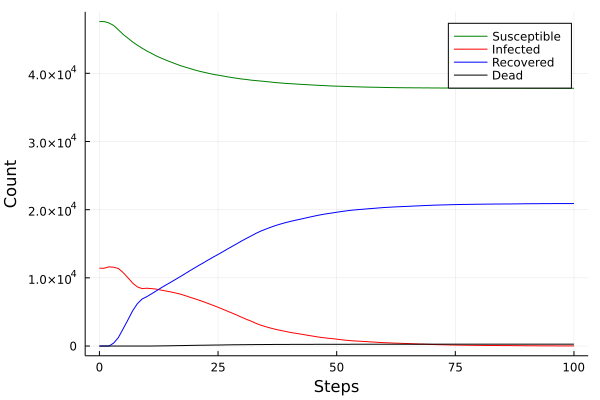

In [14]:
N = sum(model.N_total) # Total initial population
x = data.step
Plots.plot(x, (data[:, aggname(:status, length)].-data[:, aggname(:status, recovered)]
        .-data[:, aggname(:status, infected)]), color = :green,label="Susceptible",xlabel="Steps",ylabel="Count")
Plots.plot!(x, (data[:, aggname(:status, infected)]), color = :red,label="Infected")
Plots.plot!(x, (data[:, aggname(:status, recovered)]), color = :blue,label="Recovered")
Plots.plot!(x, (N .- data[:, aggname(:status, length)]), color = :black,label="Dead")